In [1]:
import numpy as np
import pandas as pd
import spacy
import string
import gensim
from gensim import corpora as corpora
from gensim.models import LsiModel, TfidfModel
from operator import itemgetter
from gensim.similarities import MatrixSimilarity
import operator
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from spacy.lang.en.stop_words import STOP_WORDS
import unicodedata
from tqdm import tqdm
import random
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## 1. Data Ingestion and Preprocessing

In this initial step, you import the necessary libraries and load the dataset containing movie plots. This could involve reading a CSV or JSON file that includes movie titles and their corresponding plot summaries. The goal is to have a structured dataset that you can manipulate and analyze throughout the process.

In [22]:
# https://www.kaggle.com/datasets/ashpalsingh1525/imdb-movies-dataset
df = pd.read_csv('imdb_movies.csv')
df.head()

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


In [23]:
df = df.drop(['date_x','orig_title', 'status', 'orig_lang', 'budget_x', 'revenue', 'country' ], axis=1)
df.head()

,names,score,genre,overview,crew
0,Creed III,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso..."
1,Avatar: The Way of Water,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt..."
2,The Super Mario Bros. Movie,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P..."
3,Mummies,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor..."
4,Supercell,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin..."


In [24]:
print('Number of duplicated rows: ' , len(df[df.duplicated()]))
df = df.drop_duplicates()
print('After removing duplicated rows: ' , len(df[df.duplicated()]))

Number of duplicated rows:  178
After removing duplicated rows:  0


Before dropping NaN values:


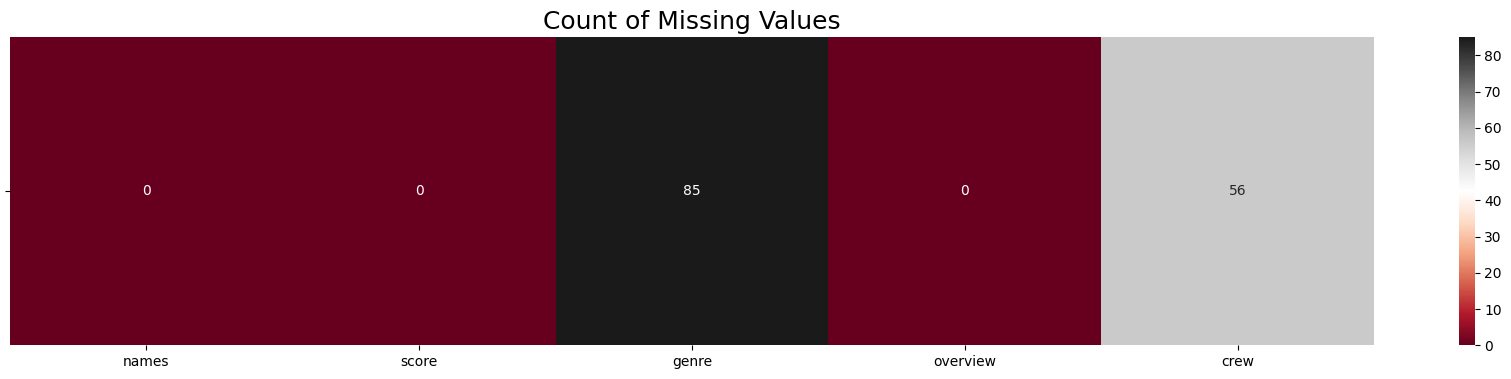

After dropping NaN values:


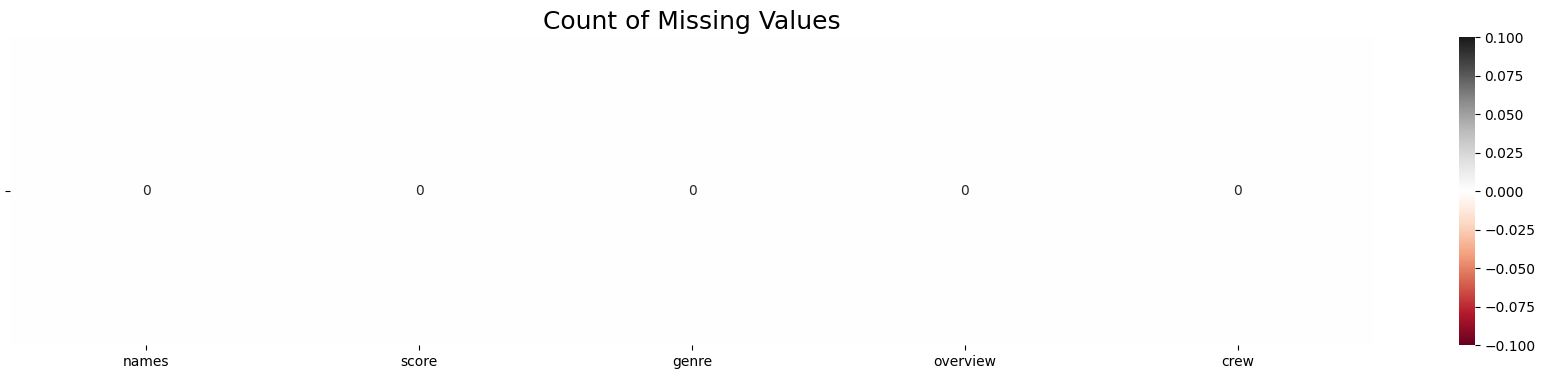

In [25]:
def plot_nan(df):
    plt.figure(figsize=(22,4))
    sns.heatmap((df.isna().sum()).to_frame(name='').T,cmap='RdGy', annot=True,
                fmt='0.0f').set_title('Count of Missing Values', fontsize=18)
    plt.show()

print("Before dropping NaN values:")
plot_nan(df)

df.dropna(inplace=True)
print("After dropping NaN values:")
plot_nan(df)

In [81]:
def check_df(df: object, head: object = 5) -> object:
    print("\nShape")
    print(df.shape)
    print("\nTypes")
    print(df.dtypes)
    print("\nNANs")
    print(df.isnull().sum())
    print("\nInfo")
    print(df.info())

check_df(df)


Shape
(9874, 8)

Types
names              object
score             float64
genre              object
overview           object
crew               object
plot_tokenized     object
crew_tokenized     object
id                  int64
dtype: object

NANs
names             0
score             0
genre             0
overview          0
crew              0
plot_tokenized    0
crew_tokenized    0
id                0
dtype: int64

Info
<class 'pandas.core.frame.DataFrame'>
Index: 9874 entries, 0 to 10177
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   names           9874 non-null   object 
 1   score           9874 non-null   float64
 2   genre           9874 non-null   object 
 3   overview        9874 non-null   object 
 4   crew            9874 non-null   object 
 5   plot_tokenized  9874 non-null   object 
 6   crew_tokenized  9874 non-null   object 
 7   id              9874 non-null   int64  
dtypes: float64(1

In [27]:
# finding unique data
df.apply(lambda x: len(x.unique()))

,0
names,9538
score,78
genre,2300
overview,9810
crew,9857


## 2. Cleaning and Tokenizing the Data

Once the data is loaded, the next step is to clean it. This involves removing unnecessary elements that could hinder the analysis:

1. Removing Stopwords: These are common words (e.g., "the," "is," "in") that don’t carry significant meaning and can be filtered out to reduce noise.
2. Removing Punctuation: Punctuation marks can disrupt the tokenization process, so it’s essential to remove them from the text.

After cleaning the plots, the next step is to tokenize the text. Tokenization involves splitting the cleaned plot into individual words or phrases, which makes it easier to analyze and process the text.

In [38]:
# Load spacy model
spacy_nlp = spacy.load('en_core_web_sm')

# Pre-compile regex patterns for performance improvement
regex_patterns = [
    (re.compile(r"\'"), ''),  # Remove single quotes
    (re.compile(r"\w*\d\w*"), ''),  # Remove digits and words containing digits
    (re.compile(r'\n|\t'), ' '),  # Replace new line or tab with a single space
    (re.compile(r' +'), ' '),  # Replace multiple spaces with single space
]

# Punctuation and stop words
punctuations = set(string.punctuation)
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def clean_text(sentence):
    # Normalize unicode characters (for accented words etc.)
    sentence = unicodedata.normalize('NFKD', sentence)

    # Apply all regex patterns
    for pattern, repl in regex_patterns:
        sentence = re.sub(pattern, repl, sentence)

    return sentence

# Enhanced tokenizer function using Spacy and the improvements
def spacy_tokenizer(sentence):
    # Step 1: Clean the sentence
    sentence = clean_text(sentence)

    # Step 2: Tokenization using Spacy
    tokens = spacy_nlp(sentence)

    # Step 3: Process tokens (lemmatization, lowercasing, filtering)
    processed_tokens = [
        token.lemma_.lower().strip()
        for token in tokens
        if token.lemma_ != "-PRON-"  # Avoid personal pronouns
        and token.text not in punctuations  # Remove punctuation
        and token.text.lower() not in stop_words  # Remove stop words
        and len(token.text) > 2  # Exclude very short words
    ]

    return processed_tokens

# Applying the tokenizer to the dataframe
print('Cleaning and Tokenizing...')
tqdm.pandas()  # Activate tqdm for pandas

df['plot_tokenized'] = df['overview'].progress_map(spacy_tokenizer)
df.head()

Cleaning and Tokenizing...


100%|██████████| 9874/9874 [03:47<00:00, 43.47it/s]


,names,score,genre,overview,crew,plot_tokenized
0,Creed III,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...","[dominate, boxing, world, adonis, creed, thriv..."
1,Avatar: The Way of Water,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...","[set, decade, event, film, learn, story, sully..."
2,The Super Mario Bros. Movie,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...","[work, underground, fix, water, main, brooklyn..."
3,Mummies,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...","[series, unfortunate, event, mummy, end, prese..."
4,Supercell,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...","[good, hearted, teenager, william, live, hope,..."


In [39]:
print('Tokenizing crew members...')
tqdm.pandas()  # Activate tqdm for pandas

df['crew_tokenized'] = df['crew'].progress_map(spacy_tokenizer)
df.head()

Tokenizing crew members...


100%|██████████| 9874/9874 [04:14<00:00, 38.87it/s]


,names,score,genre,overview,crew,plot_tokenized,crew_tokenized
0,Creed III,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...","[dominate, boxing, world, adonis, creed, thriv...","[michael, jordan, adonis, creed, tessa, thomps..."
1,Avatar: The Way of Water,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...","[set, decade, event, film, learn, story, sully...","[sam, worthington, jake, sully, zoe, saldaña,..."
2,The Super Mario Bros. Movie,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...","[work, underground, fix, water, main, brooklyn...","[chris, pratt, mario, voice, anya, taylor, joy..."
3,Mummies,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...","[series, unfortunate, event, mummy, end, prese...","[óscar, barberán, thut, voice, ana, esther, ..."
4,Supercell,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...","[good, hearted, teenager, william, live, hope,...","[skeet, ulrich, roy, cameron, anne, heche, qui..."


In [71]:
# add df id
df['id'] = range(0, len(df))
df.head()
df.to_csv('tokenized_df.csv', index=False)

In [41]:
movie_plot = df['plot_tokenized']
movie_crew = df['crew_tokenized']
print("The number of tokens in first row: ",len(movie_plot[0]))

The number of tokens in first row:  37


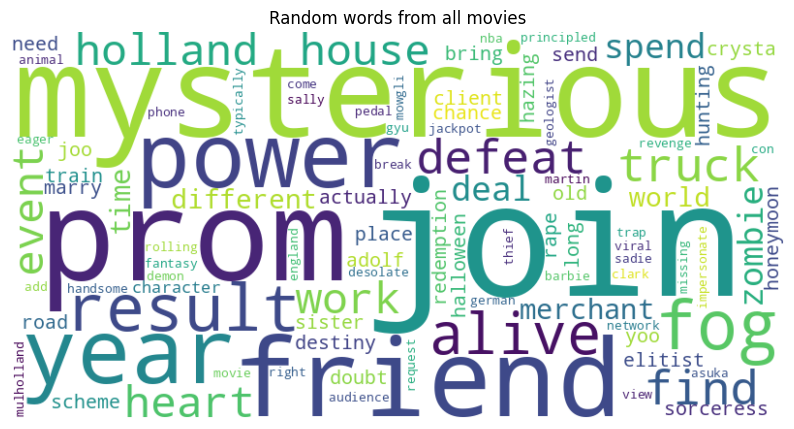

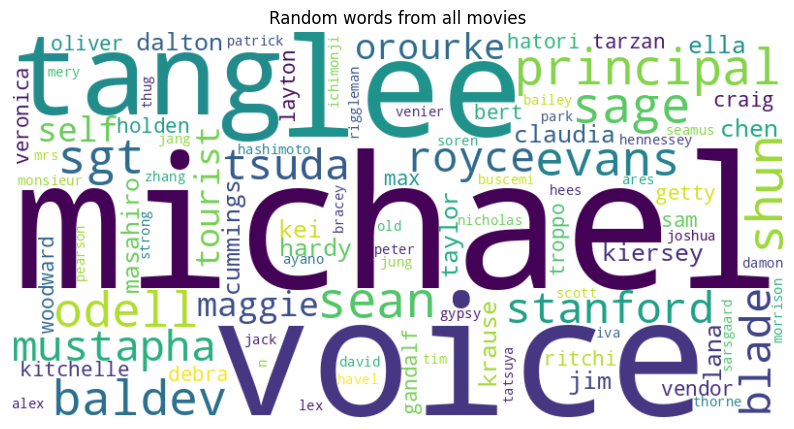

In [100]:
def plot_wordcloud(lists):
    all_words = [word for sublist in lists for word in sublist]
    some_words = random.sample(all_words, 100)

    # Create a string from the list of words
    text = " ".join(some_words)

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Random words from all movies")
    plt.show()

plot_wordcloud(movie_plot)
plot_wordcloud(movie_crew)

## 3. Creating Corpus of words

Process a list of movie plots to create a dictionary, filter out extreme terms,
and return the word frequencies of the first few documents.

In [93]:
def process_corpus(inputs, custom_stoplist=None, no_below=4, no_above=0.2, top_n=50):
    """
    Process a list of movie plots to create a dictionary, filter out extreme terms,
    and return the word frequencies of the first few documents.

    Args:
    - inputs (list of list of str): A list where each element is a tokenized list of words from a movie plot.
    - custom_stoplist (set of str, optional): A set of additional stopwords to be removed. Defaults to None.
    - no_below (int, optional): Filter out tokens that appear in less than `no_below` documents. Defaults to 4.
    - no_above (float, optional): Filter out tokens that appear in more than `no_above` proportion of documents. Defaults to 0.2.
    - top_n (int, optional): Number of top tokens to return. Defaults to 50.

    Returns:
    - dictionary (gensim.corpora.Dictionary): The processed dictionary of terms.
    - corpus (list of list of (int, int)): The corpus with word frequency data for each document.
    - top_tokens (list of tuples): A list of the top `top_n` tokens with their token IDs.
    - word_frequencies (list of list of tuples): The word frequencies for the first 3 documents.
    """
    # Step 1: Create a term dictionary from the movie plot data
    dictionary = corpora.Dictionary(inputs)

    # Step 2: Filter terms that appear in less than `no_below` documents or more than `no_above` proportion of documents
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)

    # Step 3: Optionally, filter out custom stopwords from the dictionary
    if custom_stoplist:
        stop_ids = [dictionary.token2id[stopword] for stopword in custom_stoplist if stopword in dictionary.token2id]
        dictionary.filter_tokens(stop_ids)

    # Step 4: Retrieve the top `top_n` tokens with their token IDs
    # top_tokens = [(dictionary[key], dictionary.token2id[dictionary[key]]) for key in range(min(top_n, len(dictionary)))]

    # Step 5: Create a Bag-of-Words (BoW) corpus from the movie plot data
    corpus = [dictionary.doc2bow(plot) for plot in movie_plot]

    # Step 6: Get word frequencies for the first 3 documents in the corpus
    word_frequencies = [
        [(dictionary[token_id], freq) for token_id, freq in doc]
        for doc in corpus
    ]

    return dictionary, corpus, word_frequencies

In [94]:
# find top words
def top_words(word_frequencies, top_n=10):
    word_counts = defaultdict(int)
    for sublist in word_frequencies:
        for word, count in sublist:
            word_counts[word] += count

    sorted_word_counts = sorted(word_counts.items(), key=operator.itemgetter(1), reverse=True)

    top_words = sorted_word_counts[:top_n]
    return top_words

def plot_words(top_words, n):
    words, frequencies = zip(*top_words)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies, color='blue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(f'Top {n} Word Frequencies in the corpus')
    plt.show()


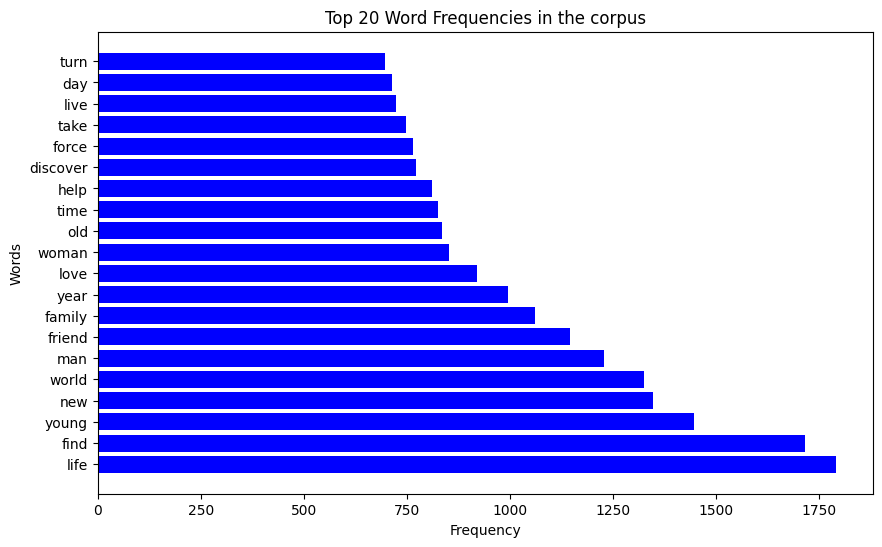

In [95]:
# custom_stoplist = {'hello', 'and', 'if', 'this', 'can', 'would', 'should', 'could', 'tell', 'ask', 'stop', 'come', 'go'}
plot_dictionary, plot_corpus, word_frequencies = process_corpus(movie_plot)

# find top n words
n = 20
top_words_plot = top_words(word_frequencies, n)
plot_words(top_words_plot, n)

## 4. TF-IDF Model with LSI Model for Visualization

With the tokens ready, you can create a Term Frequency-Inverse Document Frequency (TF-IDF) model. TF-IDF helps identify important words in the dataset relative to each plot. Then, you can apply Latent Semantic Indexing (LSI) to reduce dimensionality and visualize the relationships between movie plots.

In [57]:
def create_and_save_models(corpus, dictionary, num_topics=300, tfidf_path='movie_tfidf_model', lsi_path='movie_lsi_model'):
    """
    Creates and saves a TF-IDF model and an LSI model from the given corpus and dictionary.

    Args:
    - corpus (list of list of (int, int)): The corpus in Bag-of-Words format.
    - dictionary (gensim.corpora.Dictionary): The dictionary used for the corpus.
    - num_topics (int, optional): The number of topics for the LSI model. Defaults to 300.
    - tfidf_path (str, optional): The path to save the serialized TF-IDF corpus. Defaults to 'movie_tfidf_model_mm'.
    - lsi_path (str, optional): The path to save the serialized LSI corpus. Defaults to 'movie_lsi_model_mm'.

    Returns:
    - movie_tfidf_model (gensim.models.TfidfModel): The created TF-IDF model.
    - movie_lsi_model (gensim.models.LsiModel): The created LSI model.
    - movie_tfidf_corpus (gensim.corpora.MmCorpus): The serialized TF-IDF corpus.
    - movie_lsi_corpus (gensim.corpora.MmCorpus): The serialized LSI corpus.
    """

    # Step 1: Create a TF-IDF model from the corpus
    tfidf_model = TfidfModel(corpus, id2word=dictionary)

    # Step 2: Create an LSI model from the TF-IDF transformed corpus
    lsi_model = LsiModel(tfidf_model[corpus], id2word=dictionary, num_topics=num_topics)

    # Step 3: Save and Serialize the TF-IDF and LSI models' corpora to the specified paths
    tfidf_model.save(tfidf_path)
    lsi_model.save(lsi_path)
    # corpora.MmCorpus.serialize(tfidf_path+" corpora", tfidf_model[corpus])
    corpora.MmCorpus.serialize(lsi_path +" corpora", lsi_model[tfidf_model[corpus]])

    # Step 4: Load the serialized models back for further usage
    # tfidf_corpus = corpora.MmCorpus(tfidf_path)
    lsi_corpus = corpora.MmCorpus(lsi_path + " corpora")

    # Return the models and the loaded corpora
    return tfidf_model, lsi_model, lsi_corpus


tfidf_model, lsi_model, lsi_corpus = create_and_save_models(plot_corpus,
                                                            plot_dictionary,
                                                            num_topics=300,
                                                            tfidf_path='imdb_tfidf_model',
                                                            lsi_path='imdb_lsi_model'
                                                        )

print(tfidf_model, lsi_model)
print(lsi_corpus)


TfidfModel<num_docs=9874, num_nnz=207798> LsiModel<num_terms=7058, num_topics=300, decay=1.0, chunksize=20000>
MmCorpus(9874 documents, 300 features, 2961900 non-zero entries)


## 5. Finding Similarity with MatrixSimilarity

Next, you will calculate the similarity between movie plots using the MatrixSimilarity approach. This method measures how similar each movie plot is to others in the dataset based on the LSI matrix. You can use cosine similarity or another metric to quantify these similarities.

In [115]:
def search_similar_movies(search_term, df, dictionary, tfidf_model_path, lsi_model_path, num_results=10):
    """
    Search for movies similar to a given search term using an LSI model.

    Returns:
    - pd.DataFrame: DataFrame containing the top `num_results` similar movies with their relevance, title, and plot.
    """

    # Step 1: Tokenize and convert the search term to a Bag-of-Words format
    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))

    if not query_bow:
        raise ValueError("The query did not match any terms in the dictionary. Try a different search term.")

    # Step 2: Convert BoW to TF-IDF
    tfidf_model = TfidfModel.load(tfidf_model_path)
    query_tfidf = tfidf_model[query_bow]

    # Step 3: Convert TF-IDF to LSI representation
    lsi_model = LsiModel.load(lsi_model_path)
    query_lsi = lsi_model[query_tfidf]

    # Step 4: Create a similarity model from Lsi corpus
    lsi_corpus = corpora.MmCorpus(lsi_model_path + " corpora")
    movie_index = MatrixSimilarity(lsi_corpus, num_features=lsi_corpus.num_terms)

    # Step 5: Find similar movies using the LSI index
    movie_index.num_best = num_results
    similar_movies = movie_index[query_lsi]
    # similarity_matrix = movie_index.get_similarities(query_lsi)

    # Sort the list of movies by relevance (similarity score)
    similar_movies.sort(key=itemgetter(1), reverse=True)

    # Step 5: Prepare the result with movie titles and plot synopses
    movie_results = [
        {
            'Relevance': round(movie[1] * 100, 2),
            'Movie Title': df['names'].iloc[int(movie[0])],
            'Movie Plot': df['overview'].iloc[int(movie[0])]
        }
        for movie in similar_movies
    ]

    # Return results as a DataFrame
    return pd.DataFrame(movie_results, columns=['Relevance', 'Movie Title', 'Movie Plot'])

In [59]:
import pandas as pd
import plotly.express as px

def plot_movie_titles_with_score(df_results):
  """
  Plots movie titles and their relevance scores using an interactive plot.

  Args:
    df_results (pd.DataFrame): A DataFrame containing movie titles and relevance scores.
  """

  fig = px.bar(df_results, x='Movie Title', y='Relevance',
               title='Movie Similarity based on Plot',
               labels={'Relevance': 'Relevance Score (%)', 'Movie Title': 'Movie Titles'},
               hover_data=['Movie Plot'])
  fig.update_layout(xaxis_tickangle=-45, xaxis={'categoryorder':'total descending'})
  fig.show()

In [116]:
def perform_movie_search(search_term, df):
  """
  Performs a movie search and returns the results.
  """

  return search_similar_movies(search_term, df, plot_dictionary,
                               tfidf_model_path='imdb_tfidf_model',
                               lsi_model_path ='imdb_lsi_model',
                               num_results=10)


search_results = perform_movie_search("mysterious island", df=df)
print(search_results)

   Relevance                       Movie Title  \
0      48.47                             Signs   
1      47.46             Other Side of the Box   
2      46.45                       Blue Beetle   
3      45.66                         Allegiant   
4      45.55                         They/Them   
5      45.29                   The Hidden Face   
6      45.27                            Bubble   
7      43.92                        Bang Bang!   
8      43.46  Children of the Corn: Revelation   
9      42.66                The Skin I Live In   

                                          Movie Plot  
0  A family living on a farm finds mysterious cro...  
1  A couple receives a mysterious package from an...  
2  Jaime Reyes acquires a mysterious scarab that ...  
3  Beatrice Prior and Tobias Eaton venture into t...  
4  Campers at an LGBTQ+ conversion camp endure un...  
5  A Spanish orchestra conductor deals with the m...  
6  In an abandoned Tokyo overrun by bubbles and g...  
7  A youn

## 6. Querying the Movies to Search Similar Movie Names

Finally, you’ll implement a querying mechanism that allows users to input a search term or movie title. The notebook should retrieve and display movies with plots similar to the query based on the similarity scores calculated earlier.

In [102]:
search_term = 'give me an adventure story like in a jungle or forest'
df_results = perform_movie_search(search_term, df = df)
plot_movie_titles_with_score(df_results)

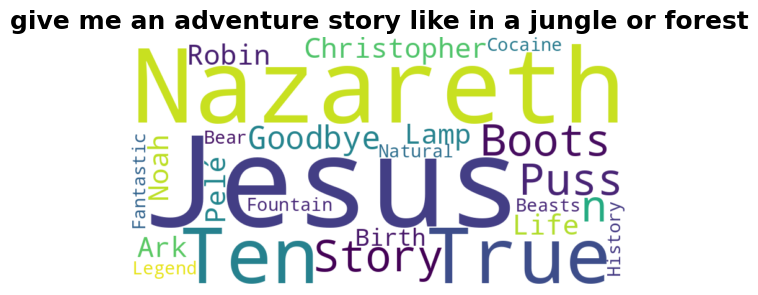

In [104]:
wordcloud_before = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_results['Movie Title']))

# Display WordCloud for before processing
# plt.subplot(1, 2, 1)
plt.imshow(wordcloud_before, interpolation='bilinear')
plt.axis('off')
plt.title(search_term, fontsize=18, fontweight='bold',color='black' )
plt.show()